# GeoProcessing with Python - Chap. 12
## Map Classification

by Chris Garrand

IPython Notebooks with some additions and adaptations by Claude COULOMBE - PhD - Montréal

Source: https://github.com/cgarrard/osgeopy-code

Download the code and install it using: sudo -H pip3 install <path-to-ospybook-latest.zip>

Data: https://app.box.com/v/osgeopy

In [1]:
# I use the print function in this code, even though I don't in the book text,
# so that you can run it as a regular script and still get the output. You only
# get output without using print if you're using the interactive window.

# Set this variable to your osgeopy-data directory so that the following
# examples will work without editing. We'll use the os.path.join() function
# to combine this directory and the filenames to make a complete path. Of
# course, you can type the full path to the file for each example if you'd
# prefer.

import os
import sys
import shutil
import numpy as np
import scipy.ndimage
import scipy.stats
from osgeo import gdal, osr
import ospybook as pb

# Set this variable to your osgeopy-data directory so that the following
# examples will work without editing. We'll use the os.path.join() function
# to combine this directory and the filenames to make a complete path. Of
# course, you can type the full path to the file for each example if you'd
# prefer.
# data_dir = r'D:\osgeopy-data'
# data_dir
data_dir = r'/home/user/Documents/osgeopy-data/osgeopy-data/'

print("GDAL version:",gdal.__version__)


GDAL version: 2.2.3


In [2]:
# Listing12_1.py
# Function to stack raster bands.

import numpy as np
from osgeo import gdal

def stack_bands(filenames):
    """Returns a 3D array containing all band data from all files."""
    bands = []
    for fn in filenames:
        ds = gdal.Open(fn)
        for i in range(1, ds.RasterCount + 1):
            bands.append(ds.GetRasterBand(i).ReadAsArray())
    return np.dstack(bands)

print('Code loaded')

Code loaded


#### Spectral Python

Spectral Python (SPy) is a Python Open Source (MIT license) scientific package for processing spectral image data. It has functions for reading, displaying, manipulating, and classifying hyperspectral imagery.

https://www.spectralpython.net/

GitHub at https://github.com/spectralpython/spectral


C.Coulombe - To install spectral:

    > sudo pip3 install spectral

In [7]:
# Listing12_2.py
# Script to perform K-means clustering with Spectral Python.

import os
import numpy as np
import spectral
from osgeo import gdal
import ospybook as pb

# folder = r'D:\osgeopy-data\Landsat\Utah'
folder = data_dir+"Landsat/Utah/"
raster_fns = ['LE70380322000181EDC02_60m.tif',
              'LE70380322000181EDC02_TIR_60m.tif']
out_fn = 'kmeans_prediction_60m.tif'

# Stack the bands and run the analysis.
os.chdir(folder)
data = pb.stack_bands(raster_fns)
classes, centers = spectral.kmeans(data)

# Save the output.
ds = gdal.Open(raster_fns[0])
out_ds = pb.make_raster(ds, out_fn, classes, gdal.GDT_Byte)
levels = pb.compute_overview_levels(out_ds.GetRasterBand(1))
out_ds.BuildOverviews('NEAREST', levels)
out_ds.FlushCache()
out_ds.GetRasterBand(1).ComputeStatistics(False)

del out_ds, ds

spectral:INFO: k-means iteration 1 - 9903429 pixels reassigned.
spectral:INFO: k-means iteration 2 - 2151930 pixels reassigned.
spectral:INFO: k-means iteration 3 - 867856 pixels reassigned.
spectral:INFO: k-means iteration 4 - 547027 pixels reassigned.
spectral:INFO: k-means iteration 5 - 325501 pixels reassigned.
spectral:INFO: k-means iteration 6 - 214849 pixels reassigned.
spectral:INFO: k-means iteration 7 - 174003 pixels reassigned.
spectral:INFO: k-means iteration 8 - 147331 pixels reassigned.
spectral:INFO: k-means iteration 9 - 139681 pixels reassigned.
spectral:INFO: k-means iteration 10 - 132859 pixels reassigned.
spectral:INFO: k-means iteration 11 - 123494 pixels reassigned.
spectral:INFO: k-means iteration 12 - 113834 pixels reassigned.
spectral:INFO: k-means iteration 13 - 105887 pixels reassigned.
spectral:INFO: k-means iteration 14 - 102579 pixels reassigned.
spectral:INFO: k-means iteration 15 - 105211 pixels reassigned.
spectral:INFO: k-means iteration 16 - 113352 pi

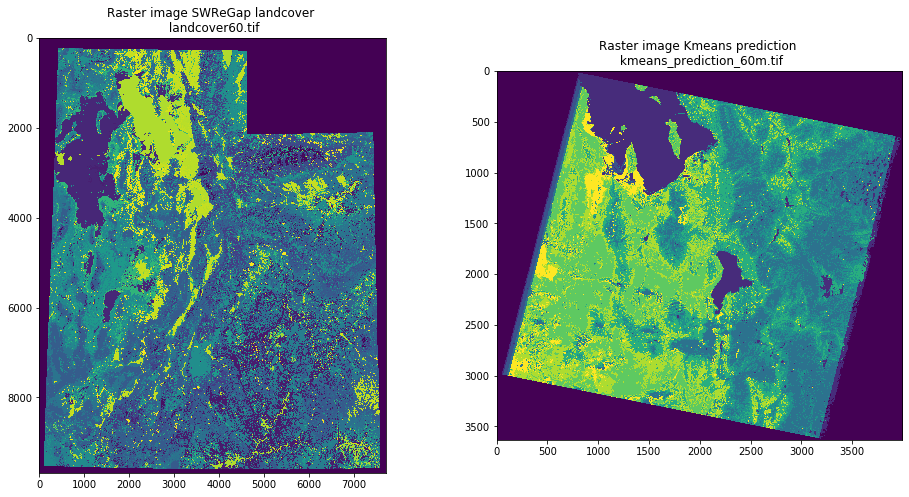

In [28]:
# C.Coulombe - show raster image
import rasterio
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
image_file = rasterio.open(data_dir+"/Utah/landcover60.tif")
image = image_file.read(1)
image_file.close()
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
ax1.title.set_text("Raster image SWReGap landcover \n landcover60.tif")
_ = ax1.imshow(image)

# C.Coulombe - show raster image
import rasterio
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
image_file = rasterio.open(data_dir + "Landsat/Utah/kmeans_prediction_60m.tif")
image = image_file.read(1)
image_file.close()
ax2 = plt.subplot(122)
ax2.title.set_text("Raster image Kmeans prediction \n kmeans_prediction_60m.tif")
_ = ax2.imshow(image)

_ = plt.show()

In [29]:
# Listing12_3.py
# Script to run a map classificatin using a classification tree.

import csv
import os
import numpy as np
from sklearn import tree
from osgeo import gdal
import ospybook as pb

data_dir = r'/home/user/Documents/osgeopy-data/osgeopy-data/'

# folder = r'D:\osgeopy-data\Landsat\Utah'
folder = data_dir+"Landsat/Utah/"

raster_fns = ['LE70380322000181EDC02_60m.tif',
              'LE70380322000181EDC02_TIR_60m.tif']

out_fn = 'tree_prediction60.tif'

# train_fn = r'D:\osgeopy-data\Utah\training_data.csv'
train_fn = data_dir+"/Utah/training_data.csv"

# gap_fn = r'D:\osgeopy-data\Utah\landcover60.tif'
gap_fn = data_dir+"/Utah/landcover60.tif"

os.chdir(folder)

# Read the coordinates and actual classification from the csv.
# This is the training data.
xys = []
classes = []
with open(train_fn) as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        xys.append([float(n) for n in row[:2]])
        classes.append(int(row[2]))

# Calculate the pixel offsets for the coordinates obtained from
# the csv.
ds = gdal.Open(raster_fns[0])
pixel_trans = gdal.Transformer(ds, None, [])
offset, ok = pixel_trans.TransformPoints(True, xys)
cols, rows, z = zip(*offset)

# Get the satellite data.
data = pb.stack_bands(raster_fns)

# C.Coulombe - I've got an error with the sampling instruction
# sample = data[rows, cols, :] which throws:
# “only integers, slices (‘:’), ellipsis (‘…’), numpy.newaxis (‘None’) 
# and integer or boolean arrays are valid indices” 
# I've guessed that the error was due to fraction of pixel offset
# Good guess! So the patch is to round-off the rows and cols
rows = [int(row_element) for row_element in rows]
cols = [int(col_element) for col_element in cols]

# Sample the satellite data at the coordinates from the csv.
sample = data[rows, cols, :]

print("sample[0]",sample[0])

# Fit the classification tree.
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(sample, classes)

print("Model have been trained")

del sample

# Apply the new classification tree model to the satellite data.
# C. Coulombe - As written in the book this could take a lot of
# memory to process, a slower approach but using less memory 
# rows, cols, bands = data.shape
# data2d = np.reshape(data, (rows * cols, bands))
# print("Data reshaped")
# prediction = clf.predict(data2d)
# prediction = np.reshape(prediction, (rows, cols))

# a slower approach but using less memory 
prediction = np.empty(data.shape[0:2])
for i in range(data.shape[0]):
    prediction[i,:] = clf.predict(data[i,:,:])

print("Prediction done")

# Set the pixels with no valid satellite data to 0.
prediction[np.sum(data, 2) == 0] = 0

# Save the output.
predict_ds = pb.make_raster(ds, out_fn, prediction, gdal.GDT_Byte, 0)
predict_ds.FlushCache()

levels = pb.compute_overview_levels(predict_ds.GetRasterBand(1))
predict_ds.BuildOverviews('NEAREST', levels)

# Apply the color table from the SWReGAP landcover raster.
gap_ds = gdal.Open(gap_fn)
colors = gap_ds.GetRasterBand(1).GetRasterColorTable()
predict_ds.GetRasterBand(1).SetRasterColorTable(colors)
# predict_ds.GetRasterBand(1).SetRasterColorInterpretation(
#     gdal.GCI_PaletteIndex)

predict_ds.FlushCache()

print("Raster image landcover created by a decision tree saved")

del ds

sample[0] [135 114  91 235]
Model have been trained
Prediction done
Raster image landcover created by a decision tree saved


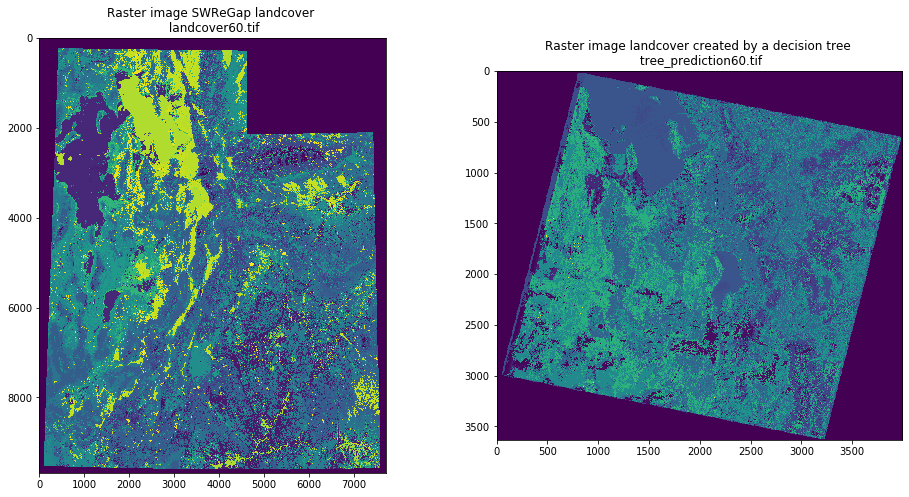

In [30]:
# C.Coulombe - show raster image
import rasterio
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
image_file = rasterio.open(data_dir+"/Utah/landcover60.tif")
image = image_file.read(1)
image_file.close()
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
ax1.title.set_text("Raster image SWReGap landcover \n landcover60.tif")
_ = ax1.imshow(image)

image_file = rasterio.open(data_dir + "Landsat/Utah/tree_prediction60.tif")
image = image_file.read(1)
image_file.close()
ax2 = plt.subplot(122)
ax2.title.set_text("Raster image landcover created by a decision tree \n tree_prediction60.tif")
_ = ax2.imshow(image)

_ = plt.show()

C.Coulombe - To install skll:

    > sudo pip3 install skll

In [16]:
# Listing12_4.py
# Script to create a confusion matrix and calculate kappa.

import csv
import os
import numpy as np
from sklearn import metrics
import skll
from osgeo import gdal

# folder = r'D:\osgeopy-data\Utah'
folder = data_dir+"Utah/"
accuracy_fn = 'accuracy_data.csv'
matrix_fn = 'confusion_matrix.csv'
# prediction_fn = r'D:\osgeopy-data\Landsat\Utah\tree_prediction60.tif'
prediction_fn = data_dir+"Landsat/Utah/tree_prediction60.tif"
os.chdir(folder)

# Collect the data needed for the accuracy assessment.
xys = []
classes = []
with open(accuracy_fn) as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        xys.append([float(n) for n in row[:2]])
        classes.append(int(row[2]))

ds = gdal.Open(prediction_fn)
pixel_trans = gdal.Transformer(ds, None, [])
offset, ok = pixel_trans.TransformPoints(True, xys)
cols, rows, z = zip(*offset)

# C.Coulombe - I've got an error with the sampling instruction
# sample = data[rows, cols, :] which throws:
# “only integers, slices (‘:’), ellipsis (‘…’), numpy.newaxis (‘None’) 
# and integer or boolean arrays are valid indices” 
# I've guessed that the error was due to fraction of pixel offset
# Good guess! So the patch is to round-off the rows and cols
rows = [int(row_element) for row_element in rows]
cols = [int(col_element) for col_element in cols]

data = ds.GetRasterBand(1).ReadAsArray()

sample = data[rows, cols]
del ds

# Compute kappa.
print('Kappa:', skll.kappa(classes, sample))

# Create the confusion matrix.
labels = np.unique(np.concatenate((classes, sample)))
matrix = metrics.confusion_matrix(classes, sample, labels)

# Add labels to the matrix and save it.
matrix = np.insert(matrix, 0, labels, 0)
matrix = np.insert(matrix, 0, np.insert(labels, 0, 0), 1)
np.savetxt(matrix_fn, matrix, fmt='%1.0f', delimiter=',')

print("\nConfusion matrix:\n",matrix)

Kappa: 0.24422110552763832

Confusion matrix:
 [[  0   2   5 ... 119 121 122]
 [  2   1   0 ...   0   0   0]
 [  5   1   0 ...   0   0   0]
 ...
 [119   0   0 ...   0   0   0]
 [121   0   0 ...   0   0   0]
 [122   0   0 ...   0   0   0]]
